# Linear Regression, Confidence Intervals, and Standard Errors

[Resource](https://harvard-iacs.github.io/2018-CS109A/lectures/lecture-5/)

# Predictor Types and Feature Selection

[Resource](https://harvard-iacs.github.io/2018-CS109A/sections/section-3/solutions/)

For this section, our goal is to discuss the complexities around different types of data features and thinking carefully about how different data types and collinearity issues can affect our models, whether our true goal is inference or prediction.

For this section, we'll use the following packages:

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)


# Other helpful functions
import itertools
import warnings
warnings.filterwarnings("ignore")

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)

# Extending Linear Regression by Transforming Predictors

Linear regression works great when our features are all continuous and all linearly affect the output. But often real data have more interesting characteristics. Here, we'll look at how we can extend linear regression to handle:
* Categorical predictors
* Interactions between predictors, which let us model how one variable changes the effect of another.

For our dataset, we'll be using the passenger list from the Titanic, which famously sank in 1912. Let's have a look at the data.

In [3]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
# Drop missing data (is this a good idea?)
titanic = titanic.dropna()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182 entries, 1 to 889
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     182 non-null    int64   
 1   pclass       182 non-null    int64   
 2   sex          182 non-null    object  
 3   age          182 non-null    float64 
 4   sibsp        182 non-null    int64   
 5   parch        182 non-null    int64   
 6   fare         182 non-null    float64 
 7   embarked     182 non-null    object  
 8   class        182 non-null    category
 9   who          182 non-null    object  
 10  adult_male   182 non-null    bool    
 11  deck         182 non-null    category
 12  embark_town  182 non-null    object  
 13  alive        182 non-null    object  
 14  alone        182 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 18.2+ KB


Let's explore this data. Most people look at differences in survival, which is important but requires knowing how to deal with categorical responses, which we'll learn how to do next lesson. For this lesson, let's see if there are systematic differences in what fare people paid.

First, let's look at the distribution of fares.

In [6]:
print(titanic.fare.describe())

count    182.000000
mean      78.919735
std       76.490774
min        0.000000
25%       29.700000
50%       57.000000
75%       90.000000
max      512.329200
Name: fare, dtype: float64


<Axes: xlabel='fare'>

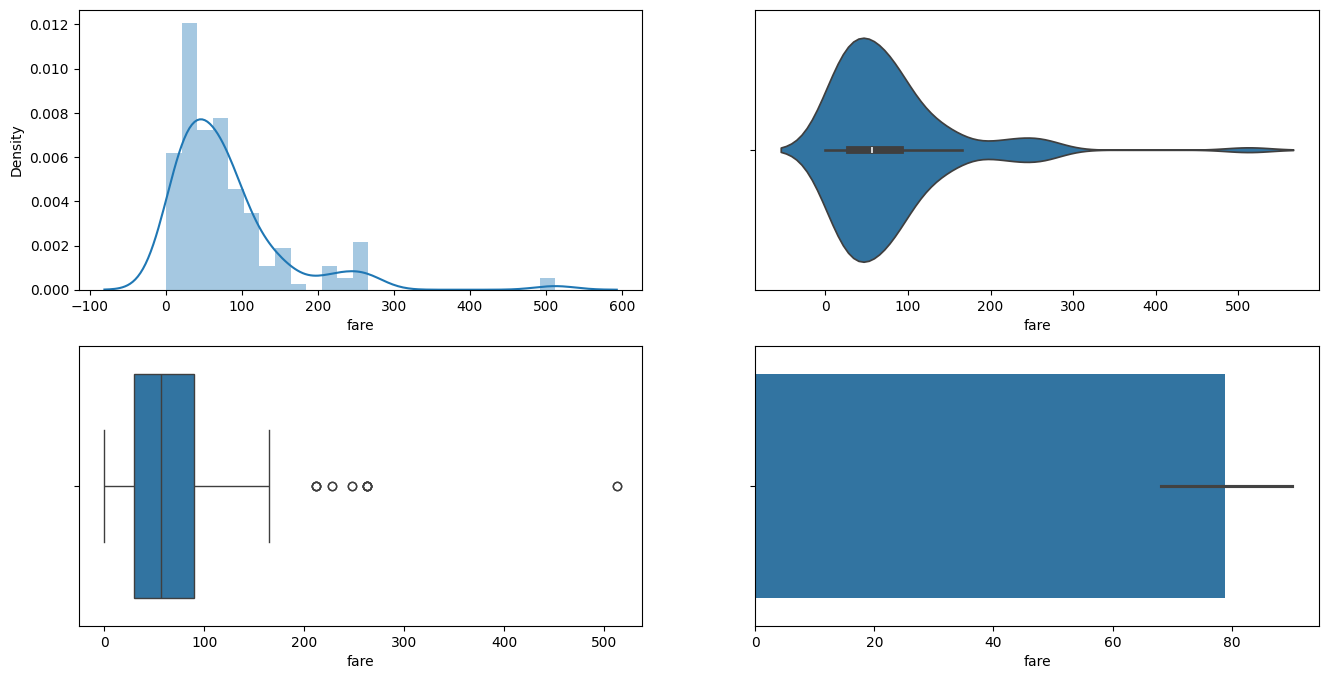

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
sns.distplot(titanic.fare, ax=axes[0,0])
sns.violinplot(x="fare", data=titanic, ax=axes[0,1])
sns.boxplot(x="fare", data=titanic, ax=axes[1,0])
sns.barplot(x="fare", data=titanic, ax=axes[1,1])

What do we learn from each visualization? Which is most helpful?

What can we say about the fares that passengers paid?\

A good visualization of the distribution of a variable will enable us to answer three kinds of questions:
* What values are typical? (mean, median, mode)
* What is the typical spread around those central values? (variance/stdev, skewness)
* What are unusual or exceptional values? (outliers)

The barplot clearly shows the mean and stdev, but that's about it. The other visualizations give complimentary info, e.g. the boxplot shows outliers clearly, but the histogram most clearly suggests that there might be secondary modes in addition to the primary mode.

Overall, we can see that most passengers paid below $50, but there are many outliers. If we were carefully analyzing the data, we might consider removing some outliers entirely and transforming the remaining data to make its distribution more normal. But for now we'll just use the data as-is.

## Exploring predictors

Cabin class is probably going to matter for fare, but we might wonder if age and gender also matter. Let's explore them.

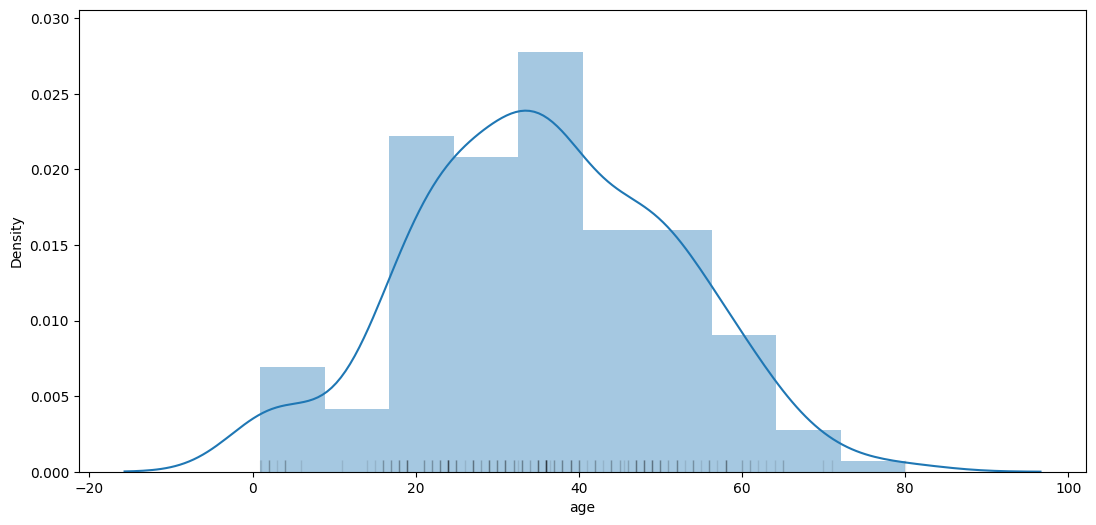

In [8]:
sns.distplot(titanic.age, rug=True, rug_kws={'alpha': .1, 'color': 'k'});

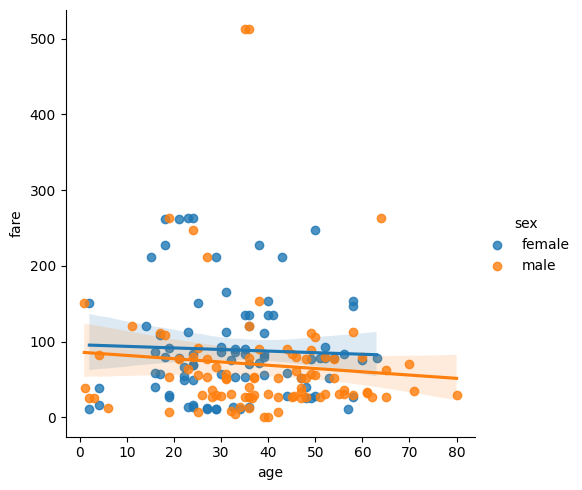

In [9]:
sns.lmplot(x="age", y="fare", hue="sex", data=titanic);

My version of Seaborn doesn't accept `size` as an argument for `lmplot`. Moreover, the professor's plot shows a positive relationship rather than the slightly negative one I'm seeing here. Either way, their main point is that males and females experience a slightly different slope in relation to fare. So we'll keep this in mind regardless.

How about sex and class?

In [10]:
print(titanic.sex.value_counts())

sex
male      94
female    88
Name: count, dtype: int64


And after seeing this, it seems like I might be working with a different data set altogether.

Let's see if the original data shows the same male and female counts as the professor's:

In [11]:
titanic2 = sns.load_dataset("titanic")
print(titanic2.sex.value_counts())

sex
male      577
female    314
Name: count, dtype: int64


Nope. I guess I might be working with different data then. Oh well!

In [12]:
print(titanic.sex.value_counts())

sex
male      94
female    88
Name: count, dtype: int64


In [13]:
titanic["class"].value_counts()

class
First     157
Second     15
Third      10
Name: count, dtype: int64

Note that we can't write `titanic.class.value_counts()` above because `class` is reserved as a keyword in Python.

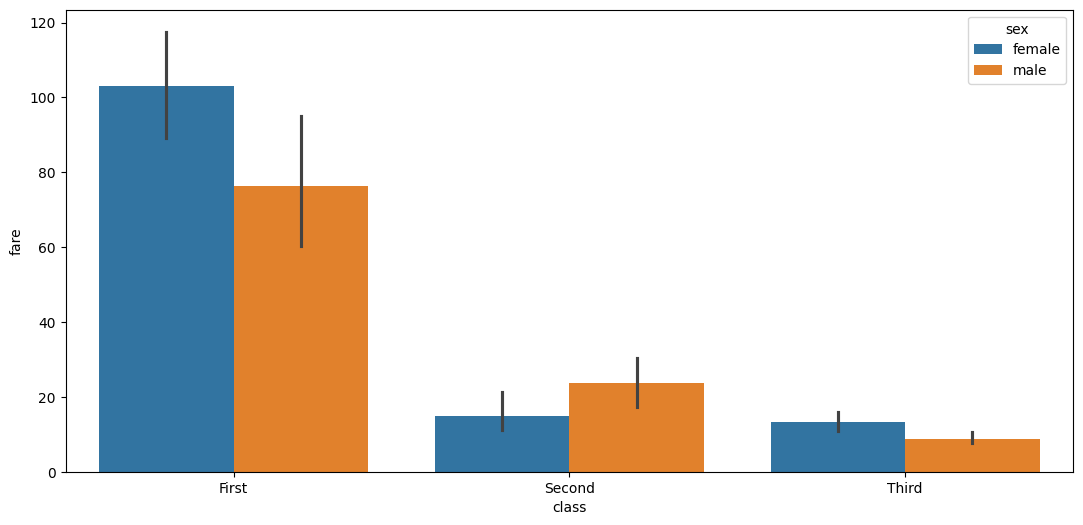

In [14]:
sns.barplot(x="class", hue="sex", y="fare", data=titanic);

Ugh, this is gonna be tricky with the different dataset I'm working with. So many tedious little obstacles in my way!

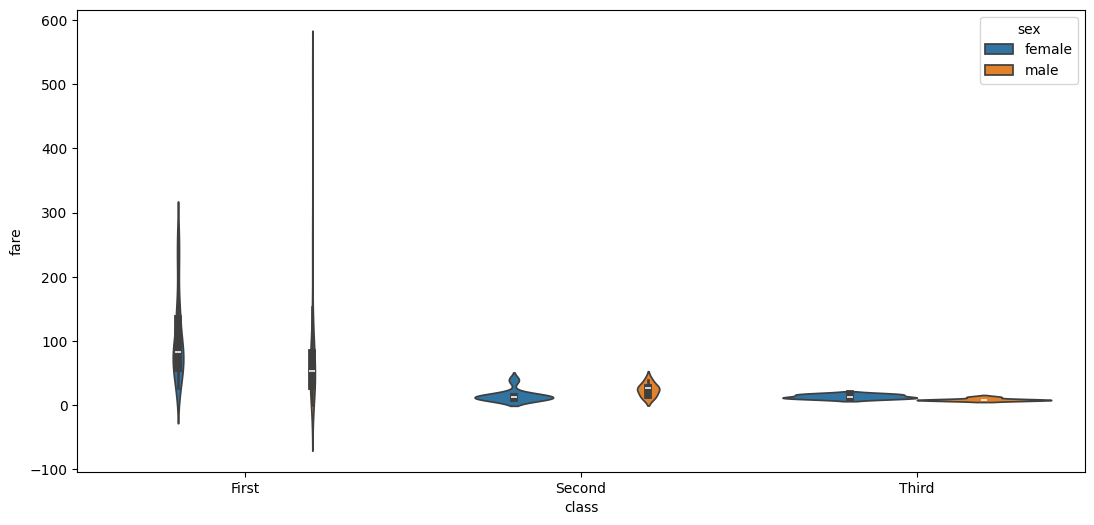

In [15]:
sns.violinplot(x="class", hue="sex", y="fare", data=titanic);

## Aside: can we replicate that violin plot without Seaborn?

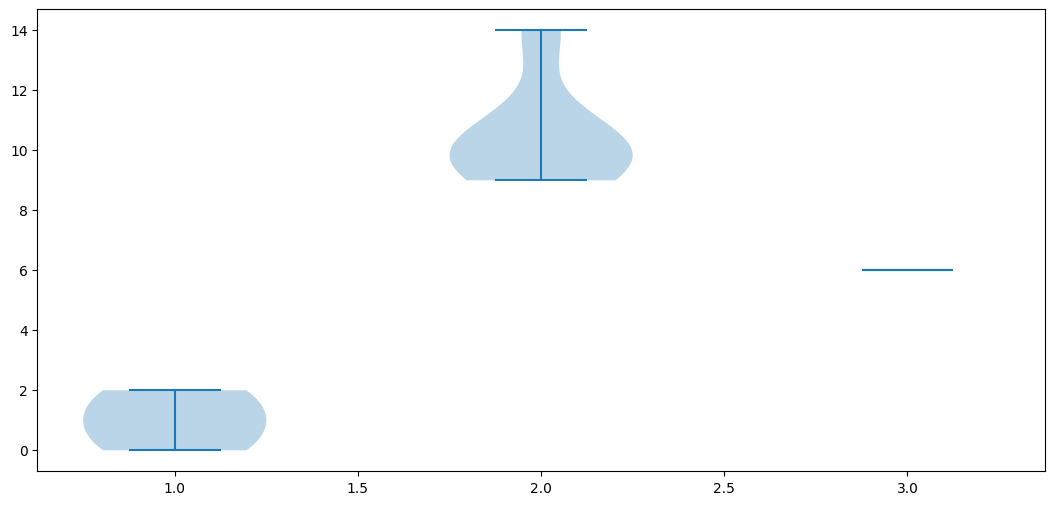

In [16]:
# plt.violinplot takes an array of data arrays, and plots each one as a separate violin.
# The data arrays don't have to be the same length.
# It returns Matplotlib objects corresponding to each of the pieces of the visualization.

plt.violinplot([
    [0,1,2], 
    [10, 14, 9, 10, 10, 10],
    [6]
]);

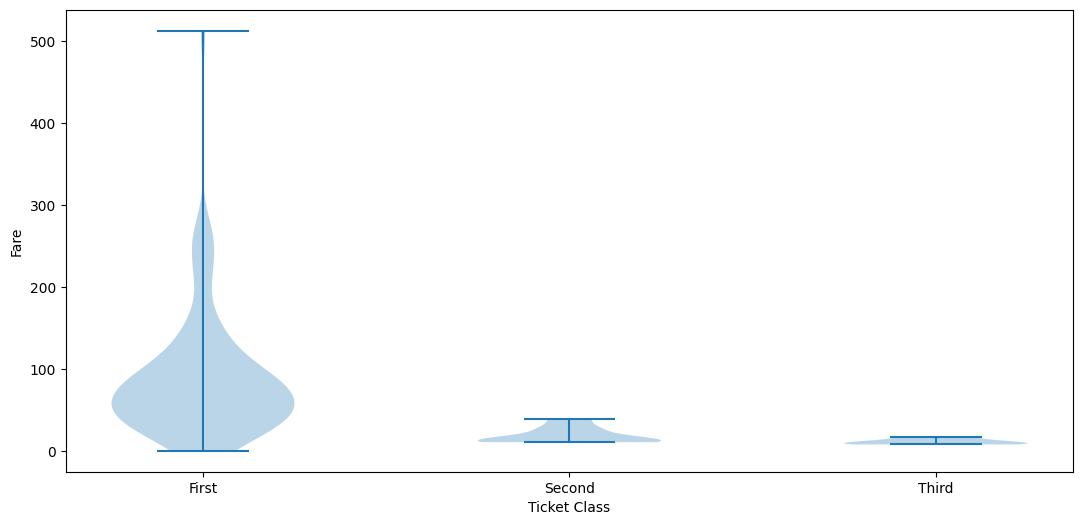

In [17]:
# We can use Pandas queries to make datasets for each class.
# We need to use `.values` to get plain Numpy arrays.
classes = 'First Second Third'.split()
plt.violinplot([
    titanic['fare'][titanic['class'] == cls].values
    for cls in classes
])
plt.xticks([1,2,3], classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

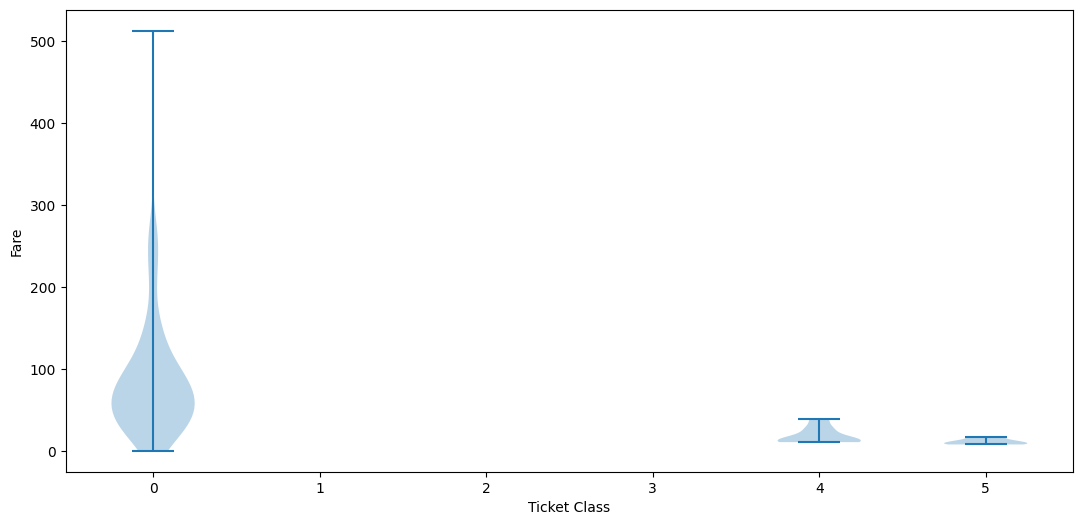

In [18]:
# It gets a little more tricky when we want to plot the two sexes side-by-side.
# Fortunately we can tell violinplot to place the violins at different positions.
position_array = [0, 4, 5] # just to show the effect of the position array.
plt.violinplot([
    titanic['fare'][titanic['class'] == cls].values
    for cls in classes
], positions=position_array)
#plt.xticks(position_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

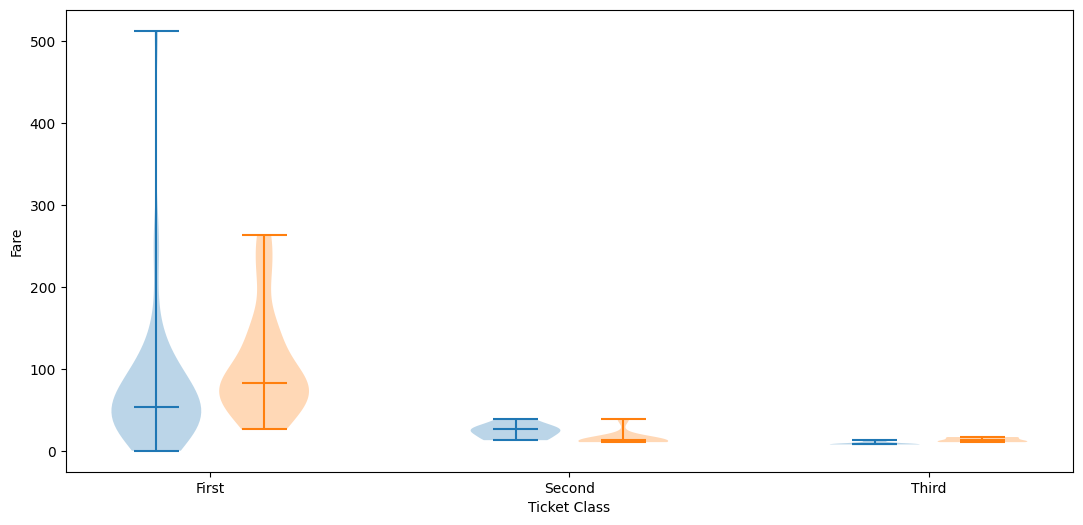

In [19]:
# We can use the position array to shift the male and female violins.

sexes = 'male female'.split()
positions_array = np.arange(len(classes)) # this will be [0, 1, 2]
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

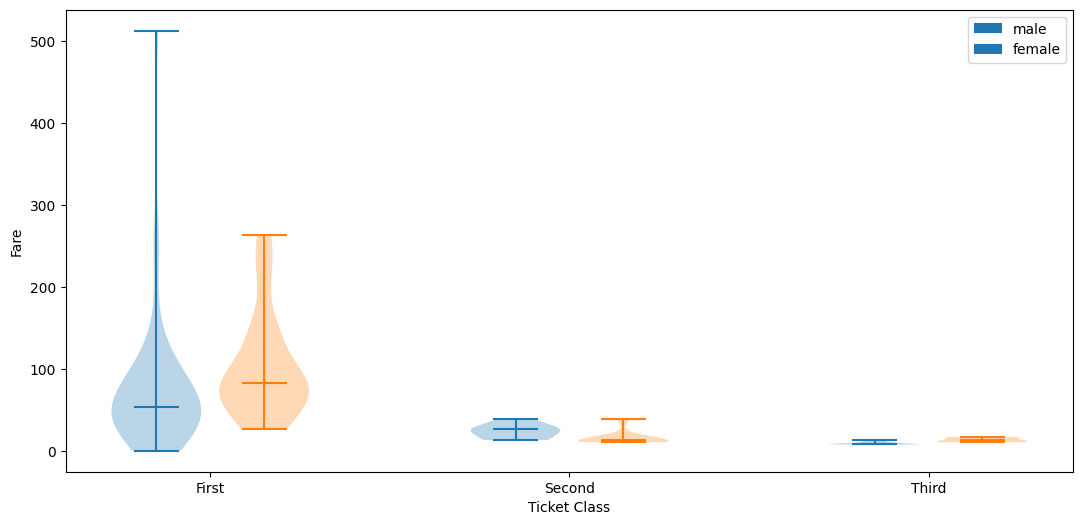

In [20]:
# But what about a legend? Unfortunately plt.violinplot doesn't support legends, so we
# have to do it by hand.
positions_array = np.arange(len(classes))
fake_handles = []
for i, sex in enumerate(sexes):
    offset = .15 * (-1 if i == 0 else 1)
    violin = plt.violinplot([
        titanic['fare'][(titanic['sex'] == sex) & (titanic['class'] == cls)].values
        for cls in classes
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)
    fake_handles.append(mpatches.Patch())
plt.legend(fake_handles, sexes)
plt.xticks(positions_array, classes)
plt.xlabel("Ticket Class")
plt.ylabel("Fare");

## Back to regressions

So it looks like fare varies with class, age, and maybe gender, and the way that fare depends on class and age may be different for male vs. female.

Let's first do a simple linear regression on age.

In [21]:
model1 = sm.OLS(
    titanic.fare,
    sm.add_constant(titanic["age"])
).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   fare   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.494
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.223
Time:                        14:39:34   Log-Likelihood:                -1046.4
No. Observations:                 182   AIC:                             2097.
Df Residuals:                     180   BIC:                             2103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.6951     14.094      6.719      0.0

According to the high p-value alone, there is not enough evidence here to reject the null hypothesis. Without considering outliers, it is highly unlikely that there is a relationship between fare and age. Again though, given that I'm working with different data the professor's results might differ. Let's plot and see what the regression looks like:

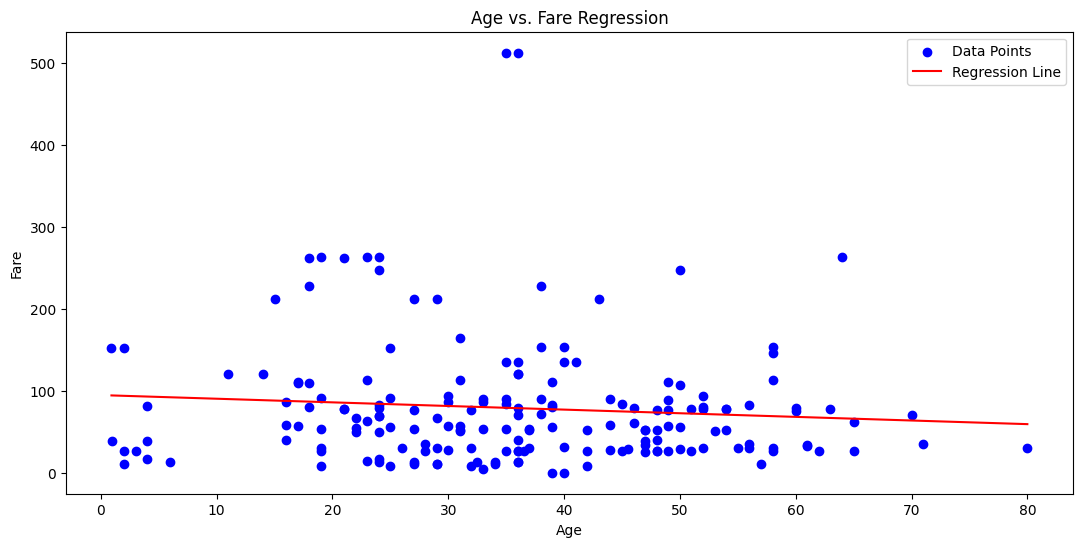

In [28]:
plt.scatter(titanic["age"], titanic["fare"], color="blue", label="Data Points")

x_range = np.linspace(titanic["age"].min(), titanic["age"].max(), 100)
y_pred = model1.params["const"] + model1.params["age"] * x_range # y = mx + b. Simple!

plt.plot(x_range, y_pred, color="red", label="Regression Line")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.title("Age vs. Fare Regression")
plt.legend()
plt.show();

And let's see if Seaborn shows the same thing both for practice and clarity:

<Axes: xlabel='age', ylabel='fare'>

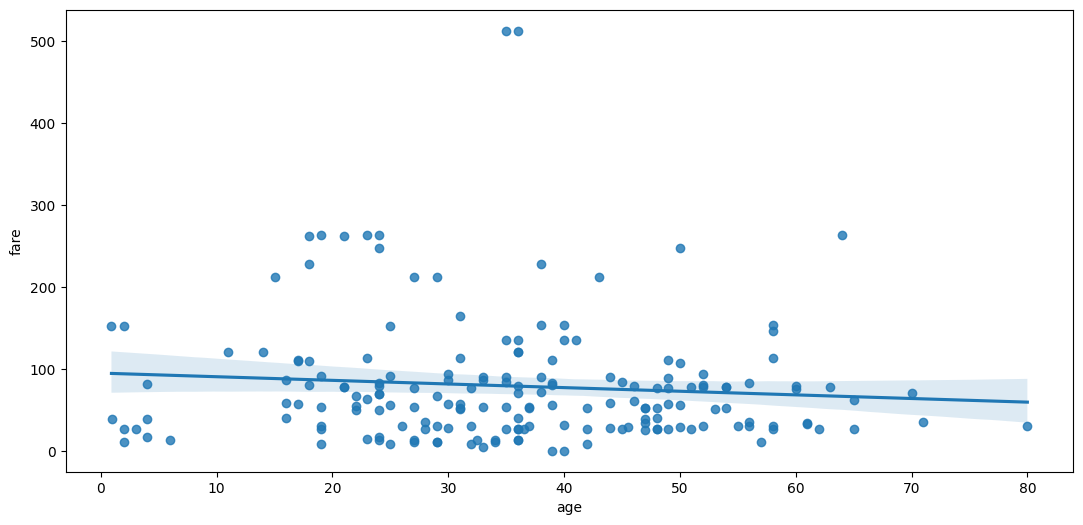

In [27]:
sns.regplot(data=titanic, x="age", y="fare")

Beautiful. Looks like things are working. These plots also indicate that the data is too spread out for this regression to be reliable. Even the more moderate outliers are affecting the regression. With little additional investigation (something we'll practice more in the actual application), it doesn't looks like age has a major affect on fare. However, this conclusion could be wrong. Anyway, let's continue.

## Handling categorical variables

Statistical packages generally distinguish between three types of variables:
* **Continuous** variables, like age and fare.
* **Nominal** variables, like gender and whether the person survived
* **Ordinal** variables like cabin class (fist, second, third)

How do we deal with gender or class? Obviously, they're categorical, so (as you know) we need to use dummy variables to encode them.

In [29]:
titanic_orig = titanic.copy()

Create a columnn `sex_male` that is 1 if the passenger is male, 0 otherwise:

In [32]:
titanic["sex_male"] = (titanic.sex == "male").astype(int)
titanic.sex_male.head()

1     0
3     0
6     1
10    0
11    0
Name: sex_male, dtype: int64

Do we need a `sex_female` column, or any others? No, because it's redundant: the only values for `sex` in this dataset are `male` and `female`, so if a passenger isn't male, we know they're female.

Now let's create columns for `class_`:

In [33]:
titanic["class_Second"] = (titanic["class"] == "Second").astype(int)
titanic["class_Third"] = (titanic["class"] == "Third").astype(int)

Now let's just do it the easy way with pandas:

In [ ]:
titanic = pd.get_dummies(titanic_orig, columns=["sex", "class"], drop_first=True)
titanic.head()

,survived,pclass,age,sibsp,parch,fare,embarked,who,adult_male,deck,embark_town,alive,alone,sex_male,class_Second,class_Third
1,1,1,38.0,1,0,71.2833,C,woman,False,C,Cherbourg,yes,False,False,False,False
3,1,1,35.0,1,0,53.1000,S,woman,False,C,Southampton,yes,False,False,False,False
6,0,1,54.0,0,0,51.8625,S,man,True,E,Southampton,no,True,True,False,False
10,1,3,4.0,1,1,16.7000,S,child,False,G,Southampton,yes,False,False,False,True
11,1,1,58.0,0,0,26.5500,S,woman,False,C,Southampton,yes,True,False,False,False


**A quick explanation**

From Claude:

`drop_first=True` removes the first category from each dummy-encoded column to avoid multicollinearity.

When you convert a categorical variable to dummy variables, you get one column per category. But this creates redundancy - if you have columns for male/female, knowing someone isn't male tells you they're female. The information is duplicated.

For example, without `drop_first`:
- `sex_male` and `sex_female` (2 columns)
- `class_First`, `class_Second`, `class_Third` (3 columns)

With `drop_first=True`:
- `sex_male` only (1 column) - absence means female
- `class_Second`, `class_Third` only (2 columns) - absence of both means First class

This matters for regression models because having all categories creates perfect collinearity - the dropped category becomes your baseline/reference group that's encoded as all zeros.